In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

from IPython.display import display, HTML

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import pickle
import seaborn as sns
import itertools
from time import time
from tqdm import tqdm_notebook

sys.path.append('..')

import warnings
warnings.filterwarnings("ignore")

In [3]:
from simulations.scenarios import *
from simulations.agent import *
from simulations.utils import Context
from scripts.parse_enron import Message

In [4]:
sns.set_context("paper", font_scale=2)
sns.set_style("white")
sns.set_palette(sns.cubehelix_palette(n_colors=4))
boxplot_kwargs = dict(
    boxprops={'linewidth': 2}, whiskerprops={'linewidth': 2},
    capprops={'linewidth': 3}, medianprops={'linewidth': 3})

In [5]:
parsed_logs_folder = '../data/enron/parsed'
simulation_reports_folder = '../data/reports'

social_graph = pickle.load(open(os.path.join(parsed_logs_folder, "social.pkl"), "rb"))
enron_log = pickle.load(open(os.path.join(parsed_logs_folder, "replay_log.pkl"), "rb"))

In [6]:
image_output_folder = '../images'
!mkdir -p $image_output_folder

### Plotting code

In [7]:
def make_encryption_status_plots(scenario_name, reports, breakpoints=None,
                                 mask_fn=None):
    if breakpoints is None:
        breakpoints = range(len(reports) + 1)
        
    fig, axes = plt.subplots(nrows=5, ncols=2)
    fig.set_figwidth(15)
    fig.set_figheight(30)
    axes = list(itertools.chain.from_iterable(axes))

    for i, (offset, report, ax) in enumerate(
            zip(breakpoints[:-1], reports, axes)):
        if mask_fn is not None:
            mask = mask_fn(report)
        else:
            mask = None
        visualize_encryption_status_history(
            '%s (log chunk @%d)' % (scenario_name, offset),
            report.encryption_status_data,
            report.link_status_data,
            log_size=LOG_CHUNK_SIZE,
            mask=mask,
            ax=ax)
        
def compute_enc_stats_in_batches(enc_status_data, link_status_data,
                                 log_size, batch_size=1000, mask=None):
    batch_stats_data = pd.DataFrame(columns=['Encrypted', 'Plaintext'])
    batch_stats_data.loc[0] = [0., 100.]
    for i in range(batch_size, log_size, batch_size):
        enc_status_batch = enc_status_data.loc[i:i+batch_size].dropna()
        link_status_batch = link_status_data.loc[i:i+batch_size].dropna()
        if mask is not None:
            mask_batch = mask.loc[i:i+batch_size]
            enc_status_batch = enc_status_batch[mask_batch]
            link_status_batch = link_status_batch[mask_batch]

        if len(enc_status_batch) == 0:
            continue

        encrypted_prop = np.mean(enc_status_batch == EncStatus.encrypted) * 100
        stale_prop = np.mean(enc_status_batch == EncStatus.stale) * 100
        
        # Proportion of initial contacts
        plain_status_batch = link_status_batch[enc_status_batch == EncStatus.plaintext]
        greeting_mask = plain_status_batch['greeting'] > 0
        followup_mask = plain_status_batch['followup'] > 0
        greeting_prop = np.sum(greeting_mask & ~followup_mask) \
                        / len(link_status_batch) * 100
        followup_prop = np.sum(followup_mask) / len(link_status_batch) * 100
        
        batch_stats_data.loc[i] = [
            encrypted_prop + stale_prop,
            greeting_prop + followup_prop
        ]

    return batch_stats_data

def visualize_encryption_status_history(
        title, enc_status_data, link_status_data, 
        log_size, batch_size=1000, mask=None, ax=None, 
        legend_kwargs=None, show_title=False, show_legend=False):

    if legend_kwargs is None:
        legend_kwargs = {}
    if ax is None:
        fig, ax = plt.subplots()
    
    batch_stats_data = compute_enc_stats_in_batches(
        enc_status_data, link_status_data, log_size, batch_size, mask=mask)
    batch_stats_data.plot.area(ax=ax)
    
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[::-1], labels[::-1], frameon=True,
                       **legend_kwargs)
    if not show_legend:
        legend.remove()
    if show_title:
        ax.set_title(title)
    ax.set_xlabel("Email sent")
    ax.set_ylabel("Encryption status (%)")
    ax.set_ylim(0, 100)
    
def get_average_diversity_data(report, log_size, batch_size=2500, mask=None):
    
    def collect_data_points(series_dict):
        data_points_by_batch = defaultdict(list)
        for offset in range(0, log_size, batch_size):
            for series in series_dict.values():
                data_slice = series.loc[offset:offset + batch_size]
                if mask is not None:
                    mask_batch = mask.loc[offset:offset+batch_size]
                    data_slice = data_slice[mask_batch]
                data_slice = data_slice.dropna().values
                if len(data_slice) == 0:
                    continue
                flattened_values = []
                for item_list in data_slice:                    
                    flattened_values.extend(item_list)
                if flattened_values:
                    data_point = np.array(flattened_values).mean()
                    data_points_by_batch[offset + batch_size].append(
                        data_point)

        for offset in range(0, log_size, batch_size):
            points = data_points_by_batch[offset + batch_size]
            data_points_by_batch[offset + batch_size] = pd.Series(points)

        result = pd.DataFrame(data_points_by_batch)
        return result

    diversity_data = collect_data_points(
        report.social_evidence_diversity_data)
    
    return diversity_data

def get_average_storage_data(report, log_size, batch_size=2500):
    
    def collect_data_points(series_dict):
        data_points_by_batch = defaultdict(list)
        for offset in range(0, log_size, batch_size):
            for series in series_dict.values():
                data_slice = series.loc[offset:offset + batch_size] \
                            .dropna().values
                if len(data_slice) == 0:
                    continue
                data_point = data_slice.mean() / 1024
                data_points_by_batch[offset + batch_size].append(data_point)

        for offset in range(0, log_size, batch_size):
            points = data_points_by_batch[offset + batch_size]
            data_points_by_batch[offset + batch_size] = pd.Series(points)

        result = pd.DataFrame(data_points_by_batch)
        return result

    bandwidth_data = collect_data_points(report.outgoing_bandwidth_data)
    gossip_storage_data = collect_data_points(report.gossip_store_size_data)
    local_storage_data = collect_data_points(report.local_store_size_data)
    
    return bandwidth_data, gossip_storage_data, local_storage_data

def get_average_enc_status_data(report, cuts, log_size, batch_size=1000, mask=None):
    enc_stats_batches = compute_enc_stats_in_batches(
        report.encryption_status_data, report.link_status_data,
        log_size=log_size, batch_size=batch_size, mask=mask)
    
    if mask is not None:
        enc_status_data = report.encryption_status_data[mask]
    else:
        enc_status_data = report.encryption_status_data
        
    enc_avg_data = pd.DataFrame(columns=['Last batch average', 'Overall average'])
    for cut in cuts:
        # Average of immediate %
        batch_avg = enc_stats_batches['Encrypted'].loc[cut-batch_size]

        # Overall average
        slice_stats = enc_status_data.loc[:cut].value_counts()
        nb_encrypted = slice_stats.get(EncStatus.encrypted) or 0 
        overall_avg = nb_encrypted / slice_stats.sum() * 100

        enc_avg_data.loc[cut] = (batch_avg, overall_avg)

    return enc_avg_data

## Determining parts of the log to simulate

In [8]:
LOG_SIZE = len(enron_log)
LOG_CHUNK_SIZE = 10000
TOTAL_NUM_CHUNKS = 11

In [9]:
breakpoints = [int(i) for i in np.linspace(0, LOG_SIZE, TOTAL_NUM_CHUNKS)]
breakpoints = breakpoints[:TOTAL_NUM_CHUNKS + 1]
breakpoints

[0, 24594, 49188, 73782, 98377, 122971, 147565, 172160, 196754, 221348, 245943]

## Plot private ClaimChain at different starting points in the log

In [10]:
private_reports = []

for i in breakpoints[:-1]:
    report_path = os.path.join(simulation_reports_folder,
                               'private_claimchain_report-%d.pkl' % i)
    with open(report_path, 'rb') as h:
        report = pickle.load(h)
        private_reports.append(report)

Global encrypted traffic

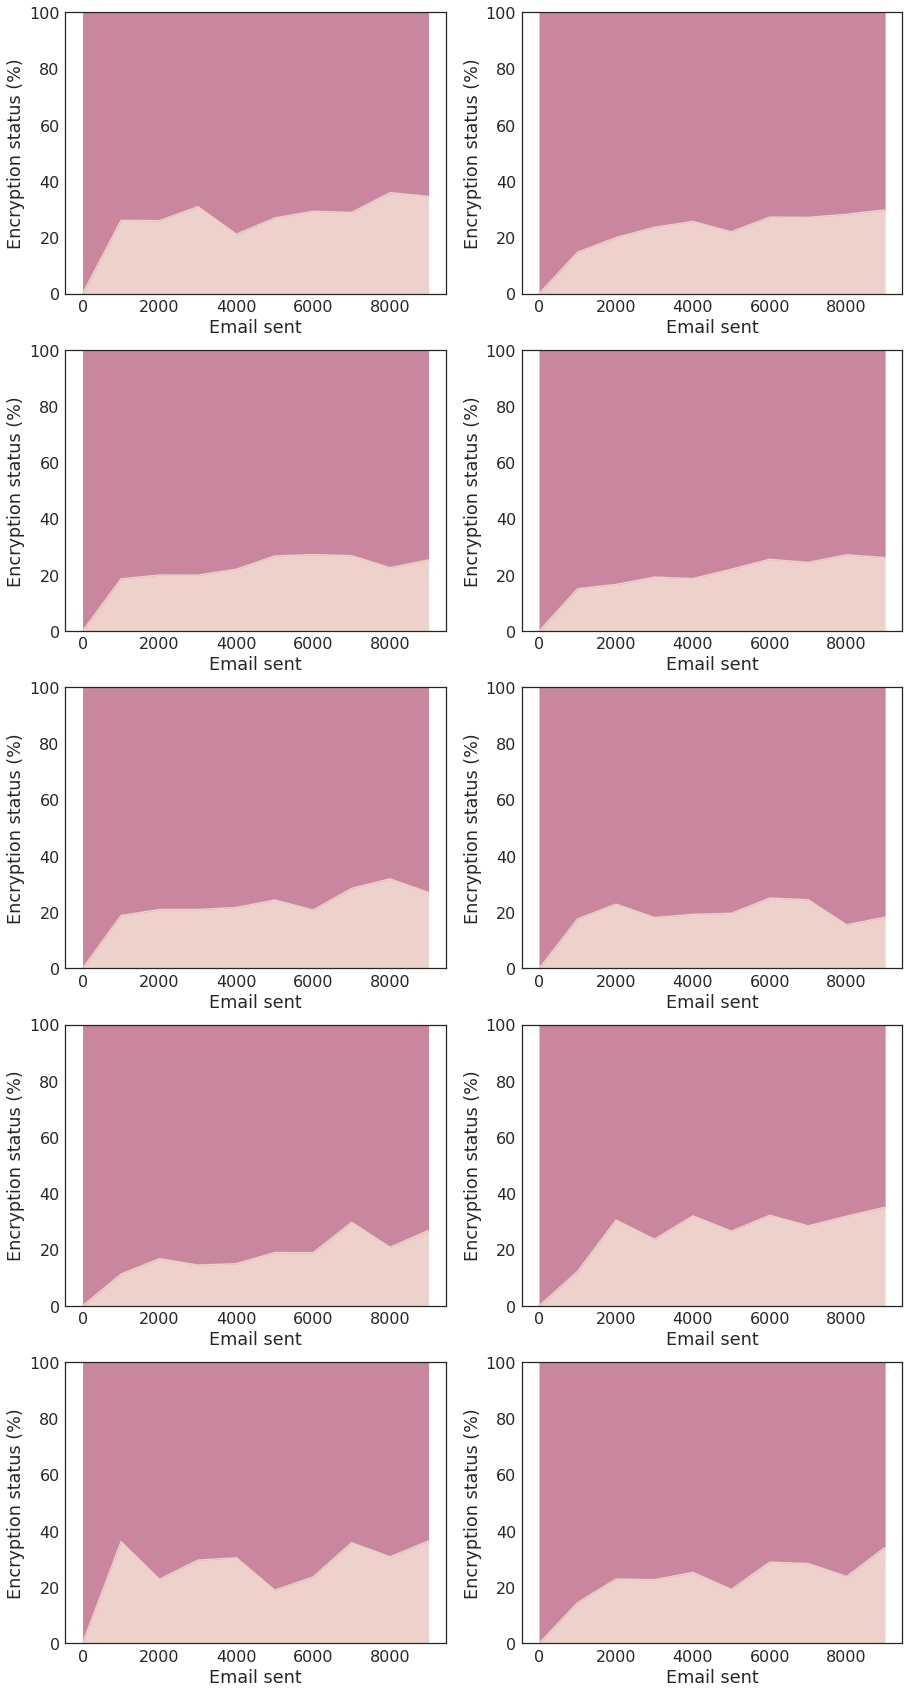

In [11]:
make_encryption_status_plots('Private ClaimChain', private_reports, breakpoints=breakpoints)

Encrypted traffic within the userset

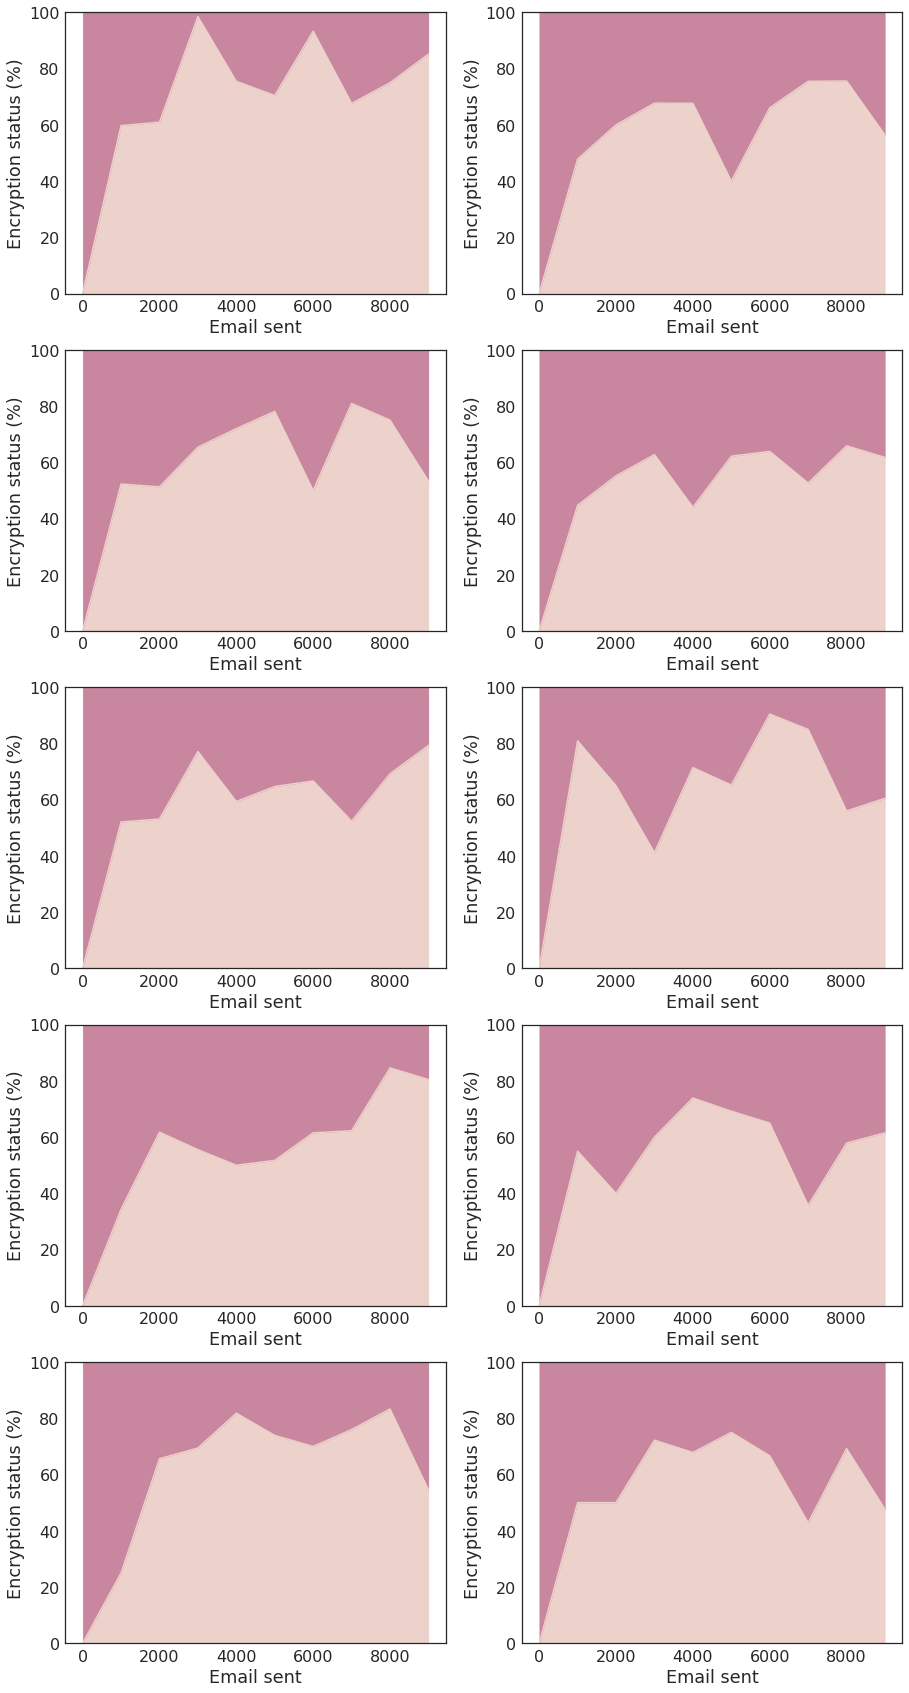

In [12]:
make_encryption_status_plots('Private ClaimChain', private_reports, breakpoints=breakpoints,
                             mask_fn=lambda report: report.participants_type_data == ParticipantsTypes.userset)

### Visualize max time between two messages in the chunk by sender

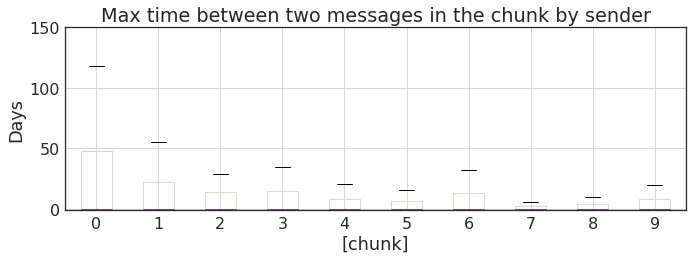

In [13]:
max_delta_send_times = pd.DataFrame(
    columns=['chunk', 'max_delta_per_sender'])

for i, breakpoint in enumerate(breakpoints[:-1]):
    email_time_data = pd.DataFrame(
        [{'email': msg.From, 'mtime': msg.mtime} for msg in enron_log[
            breakpoint:(breakpoint + LOG_CHUNK_SIZE)]])
    time_by_email = email_time_data.groupby('email')
    chunk_max_deltas_data = time_by_email.last() - time_by_email.first()
    chunk_df = pd.DataFrame(
        {'chunk': [i] * len(chunk_max_deltas_data),
         'max_delta_per_sender': chunk_max_deltas_data['mtime'] / 3600 / 24})
    max_delta_send_times = max_delta_send_times.append(
        chunk_df, ignore_index=True)
    
fig, ax = plt.subplots()
max_delta_send_times.boxplot(by='chunk', ax=ax)

plt.suptitle('')
ax.set_title('Max time between two messages in the chunk by sender')
ax.set_ylim(-1, 150)
ax.set_ylabel('Days')

fig.set_figwidth(10)
fig.set_tight_layout(tight=True)

Average encryption proportions

In [14]:
summaries = []
cuts = [2000, 4000, 6000, 8000, 10000]

for i, (offset, report) in enumerate(zip(breakpoints, private_reports)):
    display(HTML('<h4>@%d</h4>' % offset))
    a = get_average_enc_status_data(report, log_size=LOG_CHUNK_SIZE, cuts=cuts)
    b = get_average_enc_status_data(report, log_size=LOG_CHUNK_SIZE,cuts=cuts,
        mask=report.participants_type_data==ParticipantsTypes.userset)
    df = pd.concat({'global': a, 'userset': b}, axis=1)
    summaries.append(df)
    display(df)

global                            userset                
      Last batch average Overall average Last batch average Overall average
2000           26.024590       18.688525          59.756098       40.000000
4000           30.925738       22.491441          98.529412       58.000000
6000           26.895854       22.674519          70.454545       60.305344
8000           28.861789       23.957123          67.647059       62.076271
10000          34.599589       25.523574          85.185185       63.465160

global                            userset                
      Last batch average Overall average Last batch average Overall average
2000           14.720812       11.782631          47.826087       36.842105
4000           23.594378       16.776316          67.741935       47.435897
6000           21.985816       19.132782          40.000000       51.792829
8000           27.098079       21.141917          75.510204       57.303371
10000          29.757085       22.711143          56.410256       59.080460

global                            userset                
      Last batch average Overall average Last batch average Overall average
2000           18.552497       15.674300          52.272727       47.945205
4000           19.875776       17.779483          65.384615       52.173913
6000           26.694045       19.965841          78.125000       58.974359
8000           26.783868       21.706222          80.952381       60.169492
10000          25.284974       22.126260          53.333333       61.073826

global                            userset                
      Last batch average Overall average Last batch average Overall average
2000           15.030675       12.544620          44.736842       33.333333
4000           19.168357       15.192455          62.745098       47.096774
6000           21.973550       16.887530          62.162162       49.308756
8000           24.385246       18.903061          52.631579       51.612903
10000          26.109391       20.429887          61.764706       54.025974

global                            userset                
      Last batch average Overall average Last batch average Overall average
2000           18.808777       13.607925          52.083333       36.666667
4000           20.944559       17.287785          77.142857       49.044586
6000           24.318658       19.178082          64.705882       51.941748
8000           28.465608       20.514495          52.380952       53.225806
10000          27.024185       22.278057          79.310345       57.095710

global                            userset                
      Last batch average Overall average Last batch average Overall average
2000           17.616034       14.377338          80.952381       51.162791
4000           18.093174       17.439057          41.176471       52.500000
6000           19.578947       18.105750          65.217391       58.064516
8000           24.421053       19.765583          85.000000       65.454545
10000          18.232044       19.211346          60.526316       63.596491

global                            userset                
      Last batch average Overall average Last batch average Overall average
2000           11.292074        8.038585          34.285714       28.571429
4000           14.498934       11.843516          55.555556       43.548387
6000           18.954248       13.540172          51.724138       45.762712
8000           29.698858       16.295899          62.264151       50.781250
10000          26.797386       17.794701          80.487805       57.275542

global                            userset                
      Last batch average Overall average Last batch average Overall average
2000           12.247071       13.120000          55.000000       37.500000
4000           23.664921       20.200422          60.000000       43.055556
6000           26.562500       23.262734          69.230769       54.545455
8000           28.436516       25.026219          35.714286       54.193548
10000          35.074627       26.700966          61.538462       55.080214

global                            userset                
      Last batch average Overall average Last batch average Overall average
2000           36.102564       25.444096          25.000000       32.432432
4000           29.557158       25.792208          69.444444       55.238095
6000           18.887723       25.403997          73.913043       62.000000
8000           35.758836       26.483244          76.000000       64.615385
10000          36.382323       27.904554          54.545455       65.106383

global                            userset                
      Last batch average Overall average Last batch average Overall average
2000           14.435146       15.412558          50.000000       38.095238
4000           22.577320       19.084562          72.222222       48.571429
6000           19.126819       20.120794          75.000000       56.363636
8000           28.335057       22.236620          42.857143       55.118110
10000          34.090909       23.569723          47.619048       55.279503

In [15]:
# Stats over all chunks
global_last_batch_df = pd.concat(
    [s['global']['Last batch average'] for s in summaries], axis=1)
userset_last_batch_df = pd.concat(
    [s['userset']['Last batch average'] for s in summaries], axis=1)
global_overall_df = pd.concat(
    [s['global']['Overall average'] for s in summaries], axis=1)
userset_overall_df = pd.concat(
    [s['userset']['Overall average'] for s in summaries], axis=1)

def compute_stats_over_chunks(data):
    return pd.DataFrame({
        'Avg': data.mean(axis=1), 
        'Std': data.std(axis=1),
        'Std * 2.26': data.std(axis=1) * 2.26   # 95% t-val for df=9
    })

display(pd.concat({
    'Last batch average (global)': compute_stats_over_chunks(global_last_batch_df),
    'Last batch average (userset)': compute_stats_over_chunks(userset_last_batch_df),
}, axis=1))

display(pd.concat({
    'Overall average (global)': compute_stats_over_chunks(global_overall_df),
    'Overall average (userset)': compute_stats_over_chunks(userset_overall_df),
}, axis=1))

Last batch average (global)                       \
                              Avg       Std Std * 2.26   
2000                    18.483024  7.462805  16.865940   
4000                    22.290031  5.019510  11.344092   
6000                    22.497816  3.379649   7.638007   
8000                    28.224491  3.197425   7.226180   
10000                   29.335251  5.725023  12.938553   

      Last batch average (userset)                        
                               Avg        Std Std * 2.26  
2000                     50.191318  14.876291  33.620418  
4000                     66.994261  14.900865  33.675955  
6000                     65.053293  11.589107  26.191382  
8000                     63.095775  16.747641  37.849669  
10000                    64.072091  12.941074  29.246828

Overall average (global)                      Overall average (userset)  \
                           Avg       Std Std * 2.26                       Avg   
2000                 14.869058  4.640874  10.488376                 38.254920   
4000                 18.388724  3.852145   8.705847                 49.666464   
6000                 19.827220  3.385452   7.651120                 54.905935   
8000                 21.603038  3.013263   6.809974                 57.455068   
10000                22.825021  3.224235   7.286770                 59.107926   

                            
            Std Std * 2.26  
2000   6.835914  15.449165  
4000   4.820174  10.893592  
6000   5.181888  11.711068  
8000   5.340252  12.068971  
10000  3.987367   9.011450

## Plot public ClaimChain simulation data at one of the points

Pick one chunk

In [16]:
PUBLIC_LOG_SIZE = LOG_CHUNK_SIZE

In [17]:
offset = breakpoints[4]
private_report = private_reports[4]

In [18]:
report_path = os.path.join(simulation_reports_folder,
                           'public_claimchain_report-%d.pkl' % offset)
with open(report_path, 'rb') as h:
    public_report = pickle.load(h)

In [19]:
private_userset_mask = (
        pd.Series(np.array([t.value for t in private_report.participants_type_data]) \
        == ParticipantsTypes.userset.value, index=private_report.participants_type_data.index))

public_userset_mask = (
        pd.Series(np.array([t.value for t in public_report.participants_type_data]) \
        == ParticipantsTypes.userset.value, index=public_report.participants_type_data.index))


Compare public and private versions

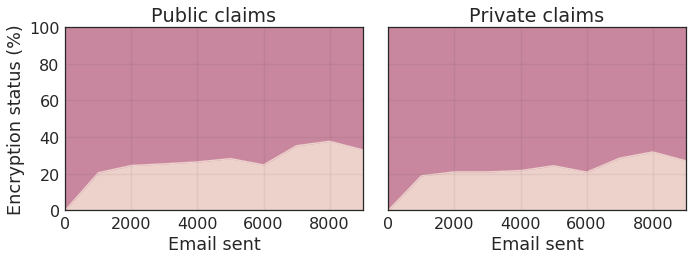

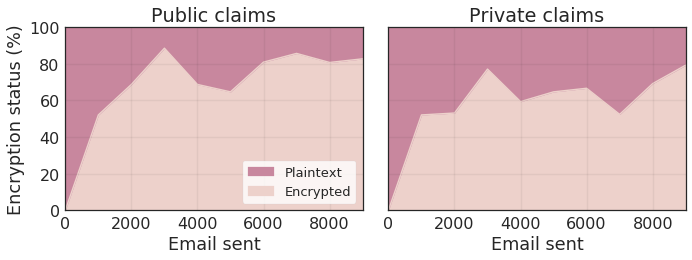

In [20]:
batch_size = 1000

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
fig.set_tight_layout(tight=True)

visualize_encryption_status_history(
    'Public claims',
    public_report.encryption_status_data,
    public_report.link_status_data,
    batch_size=batch_size,
    log_size=PUBLIC_LOG_SIZE,
    show_title=True,
    ax=axes[0])

visualize_encryption_status_history(
    'Private claims',
    private_report.encryption_status_data,
    private_report.link_status_data,
    batch_size=batch_size,
    log_size=PUBLIC_LOG_SIZE,
    show_title=True,
    ax=axes[1])

axes[0].set_xlim(0, PUBLIC_LOG_SIZE-batch_size)
axes[1].set_xlim(0, PUBLIC_LOG_SIZE-batch_size)
fig.set_figwidth(10)

for tick in [20, 40, 60, 80]:
    axes[0].axhline(tick, 0, 8000, alpha=.05, linestyle='-', color='black')
    axes[1].axhline(tick, 0, 8000, alpha=.05, linestyle='-', color='black')
    
for tick in [2000, 4000, 6000, 8000]:
    axes[0].axvline(tick, 0, 100, alpha=.05, linestyle='-', color='black')
    axes[1].axvline(tick, 0, 100, alpha=.05, linestyle='-', color='black')

fig.savefig(os.path.join(image_output_folder, 'enc_status_data_global.pdf'))

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
fig.set_tight_layout(tight=True)

visualize_encryption_status_history(
    'Public claims',
    public_report.encryption_status_data,
    public_report.link_status_data,
    mask=public_userset_mask,
    batch_size=batch_size,
    log_size=PUBLIC_LOG_SIZE,
    show_legend=True,
    show_title=True,
    ax=axes[0],
    legend_kwargs={'fontsize': 13, 'loc': 4})

visualize_encryption_status_history(
    'Private claims',
    private_report.encryption_status_data,
    private_report.link_status_data,
    mask=private_userset_mask,
    batch_size=batch_size,
    log_size=PUBLIC_LOG_SIZE,
    show_title=True,
    ax=axes[1])

axes[0].set_xlim(0, PUBLIC_LOG_SIZE-batch_size)
axes[1].set_xlim(0, PUBLIC_LOG_SIZE-batch_size)
fig.set_figwidth(10)

for tick in [20, 40, 60, 80]:
    axes[0].axhline(tick, 0, 8000, alpha=.05, color='black')
    axes[1].axhline(tick, 0, 8000, alpha=.05, color='black')
    
for tick in [2000, 4000, 6000, 8000]:
    axes[0].axvline(tick, 0, 100, alpha=.05, linestyle='-', color='black')
    axes[1].axvline(tick, 0, 100, alpha=.05, linestyle='-', color='black')
    
fig.savefig(os.path.join(image_output_folder, 'enc_status_data_userset.pdf'))

plt.show()

In [21]:
cuts=[2000, 4000, 6000, 8000, 10000]

print('Public ClaimChain')
a = get_average_enc_status_data(
    public_report, log_size=PUBLIC_LOG_SIZE,
    cuts=cuts)
b = get_average_enc_status_data(
    public_report, log_size=PUBLIC_LOG_SIZE,
    cuts=cuts,
    mask=public_userset_mask)
display(pd.concat({'global': a, 'userset': b}, axis=1))

print('Private ClaimChain')
a = get_average_enc_status_data(
    private_report, log_size=PUBLIC_LOG_SIZE,
    cuts=cuts)
b = get_average_enc_status_data(
    private_report, log_size=PUBLIC_LOG_SIZE,
    mask=private_userset_mask,
    cuts=cuts)
display(pd.concat({'global': a, 'userset': b}, axis=1))

Public ClaimChain


global                            userset                
      Last batch average Overall average Last batch average Overall average
2000           20.480669       14.598540          52.083333       38.888889
4000           25.359343       19.772257          88.571429       56.050955
6000           28.197065       22.264609          64.705882       58.737864
8000           35.238095       24.170802          85.714286       62.903226
10000          33.017876       26.381910          82.758621       66.336634

Private ClaimChain


global                            userset                
      Last batch average Overall average Last batch average Overall average
2000           18.808777       13.607925          52.083333       36.666667
4000           20.944559       17.287785          77.142857       49.044586
6000           24.318658       19.178082          64.705882       51.941748
8000           28.465608       20.514495          52.380952       53.225806
10000          27.024185       22.278057          79.310345       57.095710

## Visualize evidence diversity

In [22]:
private_diversity_data_userset = get_average_diversity_data(
    private_report,  log_size=PUBLIC_LOG_SIZE, batch_size=2500,
    mask=private_userset_mask)

private_diversity_data_global = get_average_diversity_data(
    private_report, log_size=PUBLIC_LOG_SIZE, batch_size=2500)

public_diversity_data_userset = get_average_diversity_data(
    public_report, log_size=PUBLIC_LOG_SIZE, batch_size=2500,
    mask=public_userset_mask)

public_diversity_data_global = get_average_diversity_data(
    public_report, log_size=PUBLIC_LOG_SIZE, batch_size=2500)

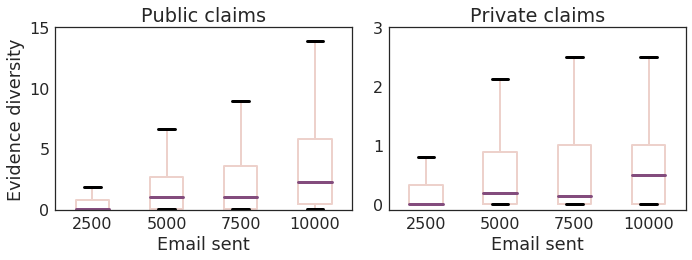

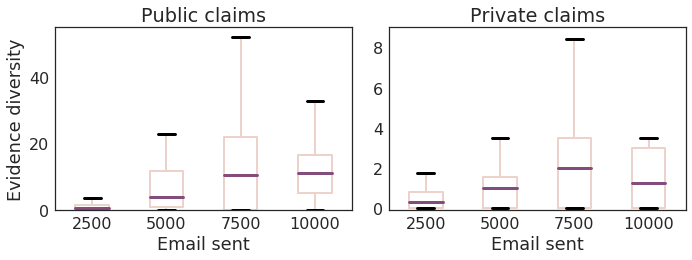

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_tight_layout(tight=True)
fig.set_figwidth(10)

ax = axes[0]
ax.set_xlabel("Email sent")
ax.set_ylabel("Evidence diversity")
ax.set_title('Public claims')
ax.set_ylim(-0.1, 15)

public_diversity_data_global.plot.box(ax=ax, **boxplot_kwargs)

ax = axes[1]
ax.set_xlabel("Email sent")
ax.set_title('Private claims')
ax.set_ylim(-0.1, 3)

private_diversity_data_global.plot.box(ax=ax, **boxplot_kwargs)

fig.savefig(os.path.join(image_output_folder, 'diversity_global.pdf'))

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_tight_layout(tight=True)
fig.set_figwidth(10)

ax = axes[0]
ax.set_xlabel("Email sent")
ax.set_ylabel("Evidence diversity")
ax.set_title('Public claims')
ax.set_ylim(-0.1, 55)

public_diversity_data_userset.plot.box(ax=ax, **boxplot_kwargs)

ax = axes[1]
ax.set_xlabel("Email sent")
ax.set_title('Private claims')
ax.set_ylim(-0.1, 9)

private_diversity_data_userset.plot.box(ax=ax, **boxplot_kwargs)

fig.savefig(os.path.join(image_output_folder, 'diversity_userset.pdf'))

plt.show()

In [24]:
def get_average_unique_prop_data(report, log_size, batch_size=2500, mask=None):
    
    def collect_data_points(unique_count_series_dict, overall_count_series_dict):
        data_points_by_batch = defaultdict(list)
        for offset in range(0, log_size, batch_size):
            
            def get_batches(series_dict):
                for series in series_dict.values():
                    data_slice = series.loc[offset:offset + batch_size]
                    if mask is not None:
                        mask_batch = mask.loc[offset:offset+batch_size]
                        data_slice = data_slice[mask_batch]

                    data_slice = data_slice.dropna().values
                    if len(data_slice) == 0:
                        continue

                    flattened_values = []
                    for item_list in data_slice:                    
                        flattened_values.extend(item_list)
                    yield flattened_values
            
            batches_gen = zip(get_batches(unique_count_series_dict),
                              get_batches(overall_count_series_dict))
            for unique_count_batch, overall_count_batch in batches_gen:
                data_point = (np.array(unique_count_batch) / np.array(overall_count_batch)).mean()
                data_points_by_batch[offset + batch_size].append(
                    data_point)

        for offset in range(0, log_size, batch_size):
            points = data_points_by_batch[offset + batch_size]
            data_points_by_batch[offset + batch_size] = pd.Series(points)

        result = pd.DataFrame(data_points_by_batch)
        return result

    unique_prop_data = collect_data_points(
        report.unique_evidence_data, report.social_evidence_diversity_data)
    
    return unique_prop_data

In [25]:
unique_prop_data = get_average_unique_prop_data(
    public_report, log_size=PUBLIC_LOG_SIZE, batch_size=PUBLIC_LOG_SIZE)
print('Public global', np.mean(unique_prop_data))

unique_prop_data = get_average_unique_prop_data(
    public_report, log_size=PUBLIC_LOG_SIZE, batch_size=PUBLIC_LOG_SIZE,
    mask=public_userset_mask)
print('Public userset', np.mean(unique_prop_data))

unique_prop_data = get_average_unique_prop_data(
    private_report, log_size=PUBLIC_LOG_SIZE, batch_size=PUBLIC_LOG_SIZE)
print('Private global', np.mean(unique_prop_data))

unique_prop_data = get_average_unique_prop_data(
    private_report, log_size=PUBLIC_LOG_SIZE, batch_size=PUBLIC_LOG_SIZE,
    mask=private_userset_mask)
print('Private userset', np.mean(unique_prop_data))

Public global 10000    0.853301
dtype: float64
Public userset 10000    0.935269
dtype: float64
Private global 10000    0.991484
dtype: float64
Private userset 10000    0.951212
dtype: float64


## Visualize storage

In [26]:
private_bandwidth_data, private_gossip_storage_data, private_local_storage_data = \
    get_average_storage_data(private_report, log_size=PUBLIC_LOG_SIZE, batch_size=2500)
public_bandwidth_data, public_gossip_storage_data, public_local_storage_data = \
    get_average_storage_data(public_report, log_size=PUBLIC_LOG_SIZE, batch_size=2500)

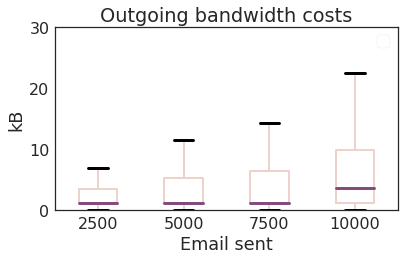

In [27]:
fig, ax = plt.subplots()
fig.set_tight_layout(tight=True)

ax.legend(frameon=True, loc="right bottom")
ax.set_ylabel("kB")
ax.set_xlabel("Email sent")
ax.set_ylim(0, 30)
ax.set_title("Outgoing bandwidth costs")

private_bandwidth_data.plot.box(ax=ax, **boxplot_kwargs)

fig.savefig(os.path.join(image_output_folder, 'private_bandwidth.pdf'))

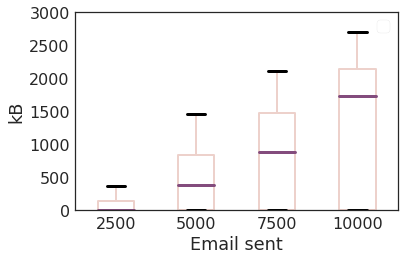

In [28]:
fig, ax = plt.subplots()
fig.set_tight_layout(tight=True)

ax.legend(frameon=True, loc="right bottom")
ax.set_ylabel("kB")
ax.set_xlabel("Email sent")
ax.set_ylim(0, 3000)
public_bandwidth_data.plot.box(ax=ax, **boxplot_kwargs)

fig.savefig(os.path.join(image_output_folder, 'public_bandwidth.pdf'))

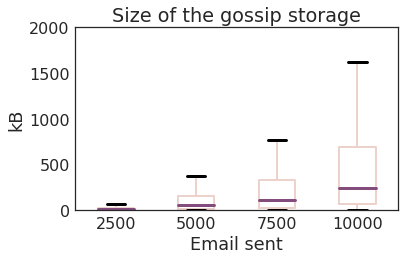

In [29]:
fig, ax = plt.subplots()
fig.set_tight_layout(tight=True)

ax.set_ylabel("kB")
ax.set_xlabel("Email sent")
ax.set_ylim(0, 2000)
ax.set_title("Size of the gossip storage")
private_gossip_storage_data.plot.box(ax=ax, **boxplot_kwargs)

fig.savefig(os.path.join(image_output_folder, 'private_gossip_storage.pdf'))

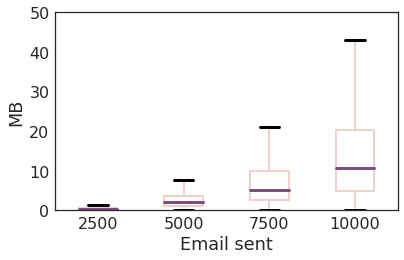

In [30]:
fig, ax = plt.subplots()
fig.set_tight_layout(tight=True)

ax.set_ylabel("MB")
ax.set_xlabel("Email sent")
ax.set_ylim(0, 50.000)
(public_gossip_storage_data / 1024).plot.box(ax=ax, **boxplot_kwargs)

fig.savefig(os.path.join(image_output_folder, 'public_gossip_storage.pdf'))

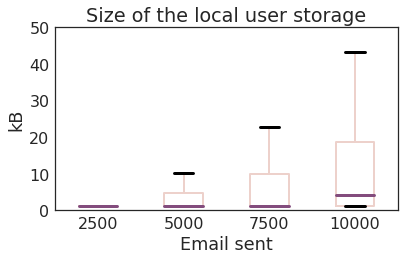

In [31]:
fig, ax = plt.subplots()
fig.set_tight_layout(tight=True)

ax.set_ylabel("kB")
ax.set_xlabel("Email sent")
ax.set_ylim(0, 50)
ax.set_title("Size of the local user storage")
private_local_storage_data.plot.box(ax=ax, **boxplot_kwargs)

fig.savefig(os.path.join(image_output_folder, 'private_local_storage.pdf'))

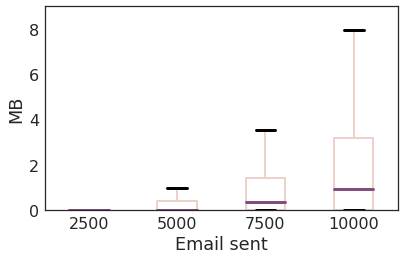

In [32]:
fig, ax = plt.subplots()
fig.set_tight_layout(tight=True)

ax.set_ylabel("MB")
ax.set_xlabel("Email sent")
ax.set_ylim(0, 9.000)
(public_local_storage_data / 1024).plot.box(ax=ax, **boxplot_kwargs)

fig.savefig(os.path.join(image_output_folder, 'public_local_storage.pdf'))